<a href="https://colab.research.google.com/github/pranjalraj28/MlProject/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#q.12

import numpy as np

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)

# Input data (XOR problem)
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
expected_output = np.array([[0], [1], [1], [0]])

# Seed for reproducibility
np.random.seed(42)

# Initialize weights and biases
w1 = np.random.rand(2, 2) # 2 inputs to 2 hidden neurons
w2= np.random.rand(2, 1) # 2 hidden neurons to 1 output
b1 = np.random.rand(1, 2) # Bias for 2 hidden neurons
b2 = np.random.rand(1, 1) # Bias for 1 output neuron

lr = 0.1

# Training loop
for epoch in range(10):
    # Forward pass
    o1 = sigmoid(np.dot(inputs,w1)+b1)

    o2 = sigmoid(np.dot(o1,w2)+b2)

    # Calculate error
    error2 = expected_output - o2

    # Backward pass
    g2 = error2 * sigmoid_derivative(o2)
    error1 = g2.dot(w2.T)
    g1 = error1 * sigmoid_derivative(o1)

    # Update weights and biases
    w2 += o1.T.dot(g2) * lr
    b2 += np.sum(g2) * lr

    w1 += inputs.T.dot(g1) * lr
    b1 += np.sum(g1) * lr

    # Print loss every 1000 epochs

    print(f'Epoch {epoch} Loss: {np.mean(np.abs(error1))}')

print("Final outputs after training:")
print(o2)


Epoch 0 Loss: 0.016477729961682674
Epoch 1 Loss: 0.015431754237720235
Epoch 2 Loss: 0.014376057302410835
Epoch 3 Loss: 0.013315580483231903
Epoch 4 Loss: 0.012255092174017407
Epoch 5 Loss: 0.011199120144684471
Epoch 6 Loss: 0.010151895309794209
Epoch 7 Loss: 0.009117307807467362
Epoch 8 Loss: 0.00809887555985709
Epoch 9 Loss: 0.007099724890398375
Final outputs after training:
[[0.63176275]
 [0.63593122]
 [0.63514226]
 [0.63841257]]


In [46]:
#q.11

import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Linear layers for query, key, and value
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        # Final linear layer after attention
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        # Compute Q, K, V matrices
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Split and reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Compute weighted sum of values
        attn_output = torch.matmul(attn_weights, V)

        # Reshape back to the original size
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)

        # Final linear layer
        output = self.out(attn_output)
        return output

# Example usage
embed_dim = 128
num_heads = 8
seq_len = 10
batch_size = 32

x = torch.randn(batch_size, seq_len, embed_dim)
self_attention = SelfAttention(embed_dim, num_heads)
output = self_attention(x)
print(output.shape)


torch.Size([32, 10, 128])


In [2]:
#q.10

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Preprocess the MNIST dataset
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
subset = Subset(dataset, range(1000))
dataloader = DataLoader(subset, batch_size=10, shuffle=True)

# Define the Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 256),  # Input: noise vector of size 100, output: hidden layer of size 256
            nn.ReLU(),            # Activation function
            nn.Linear(256, 28*28),# Output: image of size 28x28
            nn.Tanh()             # Activation function to output values between -1 and 1
        )

    def forward(self, x):
        return self.gen(x)

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(28*28, 256), # Input: image of size 28x28, output: hidden layer of size 256
            nn.ReLU(),             # Activation function
            nn.Linear(256, 1),     # Output: single value (real or fake)
            nn.Sigmoid()           # Activation function to output a probability between 0 and 1
        )

    def forward(self, x):
        return self.disc(x)

# Initialize the networks
generator = Generator()
discriminator = Discriminator()

# Define the loss function and optimizers
criterion = nn.BCELoss()
optim_gen = optim.Adam(generator.parameters(), lr=2e-4)
optim_disc = optim.Adam(discriminator.parameters(), lr=2e-4)

# Training function
def train(num_epochs):
    for epoch in range(num_epochs):
        for real, _ in dataloader:
            real = real.view( real.size(0),-1)
            batch_size = real.size(0)

            # Train Discriminator
            noise = torch.randn(batch_size, 100)
            fake = generator(noise)
            disc_real = discriminator(real)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = discriminator(fake)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

            optim_disc.zero_grad()
            loss_disc.backward()
            optim_disc.step()

            # Train Generator
            noise = torch.randn(batch_size, 100)
            fake = generator(noise)
            disc_fake = discriminator(fake)
            loss_gen = criterion(disc_fake, torch.ones_like(disc_fake))

            optim_gen.zero_grad()
            loss_gen.backward()
            optim_gen.step()

        print(f'Epoch {epoch+1}, Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}')

# Train the model for 15 epochs
train(15)


Epoch 1, Loss D: 0.5217, Loss G: 1.2033
Epoch 2, Loss D: 0.2444, Loss G: 1.9532
Epoch 3, Loss D: 0.6316, Loss G: 1.3492
Epoch 4, Loss D: 0.5270, Loss G: 1.5981
Epoch 5, Loss D: 0.4845, Loss G: 1.5185
Epoch 6, Loss D: 0.3844, Loss G: 1.5542
Epoch 7, Loss D: 0.4917, Loss G: 1.3041
Epoch 8, Loss D: 0.3729, Loss G: 1.4753
Epoch 9, Loss D: 0.3951, Loss G: 1.4010
Epoch 10, Loss D: 0.3223, Loss G: 1.1070
Epoch 11, Loss D: 0.3423, Loss G: 1.0089
Epoch 12, Loss D: 0.4282, Loss G: 0.7774
Epoch 13, Loss D: 0.4810, Loss G: 0.7846
Epoch 14, Loss D: 0.4537, Loss G: 0.8212
Epoch 15, Loss D: 0.4517, Loss G: 0.8176


In [13]:
#q.1


import numpy as np
import matplotlib.pyplot as plt

def plot_sigmoid():
    x = np.linspace(-10, 10, 100)
    y = 1 / (1 + np.exp(-x))
    plt.plot(x, y)
    plt.xlabel('Input')
    plt.ylabel('Sigmoid Output')
    plt.title('Sigmoid Activation Function')
    plt.grid(True)
    plt.show()

def plot_tanh():
    x = np.linspace(-10, 10, 100)
    y = np.tanh(x)
    plt.plot(x, y)
    plt.xlabel('Input')
    plt.ylabel('tanh(x)')
    plt.title('Hyperbolic Tangent (tanh) Activation Function')
    plt.grid(True)
    plt.show()

def plot_relu():
    x = np.linspace(-10, 10, 100)
    y = np.maximum(0, x)
    plt.plot(x, y)
    plt.xlabel('Input')
    plt.ylabel('ReLU(x)')
    plt.title('ReLU Activation Function')
    plt.grid(True)
    plt.show()

def plot_leaky_relu():
    x = np.linspace(-10, 10, 100)
    alpha = 0.1
    y = np.where(x >= 0, x, alpha * x)
    plt.plot(x, y)
    plt.xlabel('Input')
    plt.ylabel('Leaky ReLU(x)')
    plt.title('Leaky ReLU Activation Function')
    plt.grid(True)
    plt.show()

def softmax():
    x = np.array([1, 2, 3])
    e_x = np.exp(x - np.max(x))
    result = e_x / np.sum(e_x)
    print("Softmax output for [1, 2, 3]:", result)

    def plot_softmax(probabilities, class_labels):
        plt.bar(class_labels, probabilities)
        plt.xlabel("Class")
        plt.ylabel("Probability")
        plt.title("Softmax Output")
        plt.show()

    class_labels = ["Class A", "Class B", "Class C"]
    plot_softmax(result, class_labels)

def main_menu():
    while True:
        print("\nMAIN MENU")
        print("1. Sigmoid")
        print("2. Hyperbolic tangent (tanh)")
        print("3. Rectified Linear Unit (ReLU)")
        print("4. Leaky ReLU")
        print("5. Softmax")
        print("6. Exit")
        choice = int(input("Enter your choice: "))

        if choice == 1:
            plot_sigmoid()
        elif choice == 2:
            plot_tanh()
        elif choice == 3:
            plot_relu()
        elif choice == 4:
            plot_leaky_relu()
        elif choice == 5:
            softmax()
        elif choice == 6:
            break
        else:
            print("Oops! Incorrect choice. Please try again.")

# Run the main menu
main_menu()



MAIN MENU
1. Sigmoid
2. Hyperbolic tangent (tanh)
3. Rectified Linear Unit (ReLU)
4. Leaky ReLU
5. Softmax
6. Exit
Enter your choice: 6


In [15]:
#q.2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Data Preprocessing
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Creating subsets for quick testing
train_subset = Subset(train_dataset, range(200))
test_subset = Subset(test_dataset, range(50))

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

# Model Definition
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleANN()

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(output.data, dim=1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                predicted = torch.argmax(output.data, dim=1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

# Train the Model
train_model(15)


Epoch 1, Train Loss: 2.1786, Train Accuracy: 39.50%, Test Loss: 2.0067, Test Accuracy: 64.00%
Epoch 2, Train Loss: 1.6348, Train Accuracy: 66.50%, Test Loss: 1.5135, Test Accuracy: 56.00%
Epoch 3, Train Loss: 1.0204, Train Accuracy: 77.50%, Test Loss: 1.1520, Test Accuracy: 66.00%
Epoch 4, Train Loss: 0.5873, Train Accuracy: 90.00%, Test Loss: 0.8492, Test Accuracy: 72.00%
Epoch 5, Train Loss: 0.3849, Train Accuracy: 92.00%, Test Loss: 0.7225, Test Accuracy: 78.00%
Epoch 6, Train Loss: 0.2499, Train Accuracy: 96.00%, Test Loss: 0.7148, Test Accuracy: 76.00%
Epoch 7, Train Loss: 0.1646, Train Accuracy: 98.00%, Test Loss: 0.6246, Test Accuracy: 86.00%
Epoch 8, Train Loss: 0.1146, Train Accuracy: 99.00%, Test Loss: 0.6294, Test Accuracy: 84.00%
Epoch 9, Train Loss: 0.0806, Train Accuracy: 99.50%, Test Loss: 0.5697, Test Accuracy: 84.00%
Epoch 10, Train Loss: 0.0579, Train Accuracy: 100.00%, Test Loss: 0.5579, Test Accuracy: 82.00%
Epoch 11, Train Loss: 0.0408, Train Accuracy: 100.00%, Tes

In [19]:

#q.3
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define Simple CNN without BatchNormalization and Dropout
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dense1 = nn.Linear(64 * 8 * 8, 512)
        self.dense2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x

# Define CNN with BatchNormalization and Dropout
class CNNWithBNDropout(nn.Module):
    def __init__(self):
        super(CNNWithBNDropout, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.dense1 = nn.Linear(64 * 8 * 8, 512)
        self.dense2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Creating subsets for quick testing
train_subset = Subset(train_dataset, range(200))
test_subset = Subset(test_dataset, range(50))

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

# Function to train and evaluate a model
def train(model, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(output.data, dim=1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                predicted = torch.argmax(output.data, dim=1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test

        print(f'Epoch: [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

# Train both models
model1 = SimpleCNN()
model2 = CNNWithBNDropout()

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

train(model1, optimizer1, criterion, 5)
train(model2, optimizer2, criterion, 5)


Files already downloaded and verified
Files already downloaded and verified
Epoch: [1/5], Train Loss: 2.3259, Train Accuracy: 9.50%, Test Loss: 2.2990, Test Accuracy: 6.00%
Epoch: [2/5], Train Loss: 2.2666, Train Accuracy: 14.00%, Test Loss: 2.3025, Test Accuracy: 6.00%
Epoch: [3/5], Train Loss: 2.1705, Train Accuracy: 17.50%, Test Loss: 2.1053, Test Accuracy: 24.00%
Epoch: [4/5], Train Loss: 2.0002, Train Accuracy: 30.00%, Test Loss: 2.0403, Test Accuracy: 24.00%
Epoch: [5/5], Train Loss: 1.7651, Train Accuracy: 35.50%, Test Loss: 2.0947, Test Accuracy: 22.00%
Epoch: [1/5], Train Loss: 3.5392, Train Accuracy: 14.00%, Test Loss: 2.5459, Test Accuracy: 4.00%
Epoch: [2/5], Train Loss: 2.3127, Train Accuracy: 24.00%, Test Loss: 2.3313, Test Accuracy: 10.00%
Epoch: [3/5], Train Loss: 1.8287, Train Accuracy: 35.50%, Test Loss: 1.9089, Test Accuracy: 24.00%
Epoch: [4/5], Train Loss: 1.6220, Train Accuracy: 43.00%, Test Loss: 1.9381, Test Accuracy: 32.00%
Epoch: [5/5], Train Loss: 1.4598, Tra

In [21]:
#q.9

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Data preprocessing and loading
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Creating subsets for quick testing
train_subset = Subset(train_dataset, range(200))
test_subset = Subset(test_dataset, range(50))

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

# Define AutoEncoder architecture
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, optimizer, and loss function
model = AutoEncoder()
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Define training function
def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            output = model(img)
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                img, _ = data
                img = img.view(img.size(0), -1)
                output = model(img)
                loss = criterion(output, img)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

# Train the model
train_model(10)


Epoch 1, Train Loss: 0.1360, Test Loss: 0.0760
Epoch 2, Train Loss: 0.0747, Test Loss: 0.0729
Epoch 3, Train Loss: 0.0706, Test Loss: 0.0703
Epoch 4, Train Loss: 0.0659, Test Loss: 0.0642
Epoch 5, Train Loss: 0.0584, Test Loss: 0.0555
Epoch 6, Train Loss: 0.0510, Test Loss: 0.0512
Epoch 7, Train Loss: 0.0443, Test Loss: 0.0479
Epoch 8, Train Loss: 0.0394, Test Loss: 0.0440
Epoch 9, Train Loss: 0.0358, Test Loss: 0.0421
Epoch 10, Train Loss: 0.0329, Test Loss: 0.0410


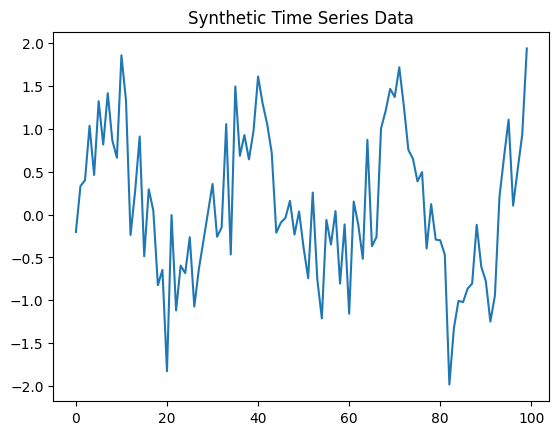

Epoch 0 loss: 0.8040476441383362
Epoch 10 loss: 5.327849388122559
Epoch 20 loss: 7.939306259155273
Epoch 30 loss: 8.115179061889648
Epoch 40 loss: 7.510571479797363
Epoch 50 loss: 8.214179992675781
Epoch 60 loss: 8.319040298461914
Epoch 70 loss: 8.330166816711426
Epoch 80 loss: 8.343399047851562
Epoch 90 loss: 8.346275329589844


In [27]:
#q.8
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic time series data
def generate_data():
    t = np.linspace(0, 20, 100)
    y = np.sin(t) + np.random.normal(scale=0.5, size=t.shape)
    return y

data = generate_data()
plt.plot(data)
plt.title('Synthetic Time Series Data')
plt.show()

# Prepare the dataset
def create_inout_sequences(input_data, tw):  # tw -> time step window
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 10  # Number of time steps to look back
data = torch.FloatTensor(data).view(-1)
sequences = create_inout_sequences(data, seq_length)

# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, num_layers=1)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        rnn_out, hidden = self.rnn(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        return predictions[-1]

# Initialize model, loss function, and optimizer
model = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100

# Training the model
for i in range(epochs):
    for seq, labels in sequences:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print(f'Epoch {i} loss: {single_loss.item()}')



In [28]:
#q.7
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Create a hypothetical dataset
data = torch.randint(0, 1000, (100, 10))  # Random integers as input data
labels = torch.randint(0, 2, (100,))      # Random binary labels
dataset = TensorDataset(data, labels)
loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Define the LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden.squeeze(0))

# Initialize model, loss function, and optimizer
model = LSTMClassifier(vocab_size=1000, embedding_dim=50, hidden_dim=100, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training function
def train(n_epochs):
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for data, targets in loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(loader)
        print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")

# Train the model
train(10)


Epoch 1, Loss: 0.6970
Epoch 2, Loss: 0.6639
Epoch 3, Loss: 0.6324
Epoch 4, Loss: 0.5870
Epoch 5, Loss: 0.5125
Epoch 6, Loss: 0.3824
Epoch 7, Loss: 0.2447
Epoch 8, Loss: 0.1159
Epoch 9, Loss: 0.0513
Epoch 10, Loss: 0.0183


In [30]:
#q.6
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Data preprocessing and loading
transform = transforms.Compose([
   transforms.ToTensor()
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, range(200))
test_subset = Subset(test_dataset, range(50))

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

# Define AlexNet architecture
class AlexNet(nn.Module):
   def __init__(self, num_classes=10):
       super(AlexNet, self).__init__()
       self.features = nn.Sequential(
           nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Conv2d(64, 192, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Conv2d(192, 384, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.Conv2d(384, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.Conv2d(256, 256, kernel_size=3, padding=1),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(kernel_size=2, stride=2),
       )
       self.classifier = nn.Sequential(
           nn.Dropout(),
           nn.Linear(256 * 3 * 3, 4096),
           nn.ReLU(inplace=True),
           nn.Dropout(),
           nn.Linear(4096, 4096),
           nn.ReLU(inplace=True),
           nn.Linear(4096, num_classes),
       )

   def forward(self, x):
       x = self.features(x)
       x = torch.flatten(x, 1)
       x = self.classifier(x)
       return x

# Initialize model, optimizer, and loss function
model = AlexNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
def train_model(num_epochs):
   for epoch in range(num_epochs):
       model.train()
       train_loss = 0.0
       correct_train = 0
       total_train = 0
       for data, target in train_loader:
           optimizer.zero_grad()
           output = model(data)
           loss = criterion(output, target)
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
           predicted = torch.argmax(output.data, dim=1)
           total_train += target.size(0)
           correct_train += (predicted == target).sum().item()
       avg_train_loss = train_loss / len(train_loader)
       train_acc = 100 * correct_train / total_train

       model.eval()
       test_loss = 0.0
       correct_test = 0
       total_test = 0
       with torch.no_grad():
           for data, target in test_loader:
               output = model(data)
               loss = criterion(output, target)
               test_loss += loss.item()
               predicted = torch.argmax(output.data, dim=1)
               total_test += target.size(0)
               correct_test += (predicted == target).sum().item()
       avg_test_loss = test_loss / len(test_loader)
       test_acc = 100 * correct_test / total_test
       print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}%, '
             f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}%')

# Train the model for 5 epochs
train_model(5)


Epoch 1, Train Loss: 2.4732, Train Accuracy: 10.5000%, Test Loss: 2.2788, Test Accuracy: 18.0000%
Epoch 2, Train Loss: 2.3042, Train Accuracy: 9.5000%, Test Loss: 2.2719, Test Accuracy: 18.0000%
Epoch 3, Train Loss: 2.2983, Train Accuracy: 13.0000%, Test Loss: 2.2594, Test Accuracy: 18.0000%
Epoch 4, Train Loss: 2.2918, Train Accuracy: 13.0000%, Test Loss: 2.2502, Test Accuracy: 18.0000%
Epoch 5, Train Loss: 2.2976, Train Accuracy: 12.5000%, Test Loss: 2.2821, Test Accuracy: 8.0000%


In [2]:
#q.4
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import Optimizer

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subset = Subset(train_dataset, range(200))
test_subset = Subset(test_dataset, range(50))

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

# Define Simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,1)

# Implement SGD and Adagrad optimizers
def sgd_update(parameters, lr):
    with torch.no_grad():
        for param in parameters:
            if param.grad is not None:
                param.data -= lr * param.grad.data
                param.grad.zero_()

class CustomAdagrad(Optimizer):
    def __init__(self, parameters, lr=0.01, epsilon=1e-10):
        self.parameters = list(parameters)
        self.lr = lr
        self.epsilon = epsilon
        self.sum_squared_gradients = [torch.zeros_like(p) for p in self.parameters]

    def step(self):
        with torch.no_grad():
            for param, sum_sq_grad in zip(self.parameters, self.sum_squared_gradients):
                if param.grad is not None:
                    sum_sq_grad += param.grad.data ** 2
                    adjusted_lr = self.lr / (self.epsilon + torch.sqrt(sum_sq_grad))
                    param.data -= adjusted_lr * param.grad.data
                    param.grad.zero_()

    def zero_grad(self):
        with torch.no_grad():
            for param in self.parameters:
                if param.grad is not None:
                    param.grad.zero_()

# Training function
device = torch.device('cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()

def train_model(num_epochs, optimizer_choice='adagrad'):
    if optimizer_choice == 'sgd':
        optimizer = None
    else:
        optimizer = CustomAdagrad(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            if optimizer_choice != 'sgd':
                optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            if optimizer_choice == 'sgd':
                sgd_update(model.parameters(), lr=0.01)
            else:
                optimizer.step()
            train_loss += loss.item()
            predicted = torch.argmax(output.data, dim=1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                predicted = torch.argmax(output.data, dim=1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()
        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}%')

# Train the model for 5 epochs using Adagrad optimizer
train_model(5, optimizer_choice='adagrad')

# Train the model for 5 epochs using SGD optimizer
model = SimpleCNN().to(device)  # Reset the model to compare fairly
train_model(5, optimizer_choice='sgd')


Epoch 1, Train Loss: 2.1900, Train Accuracy: 27.5000%, Test Loss: 1.6509, Test Accuracy: 52.0000%
Epoch 2, Train Loss: 1.2208, Train Accuracy: 70.0000%, Test Loss: 1.1143, Test Accuracy: 68.0000%
Epoch 3, Train Loss: 0.5971, Train Accuracy: 83.5000%, Test Loss: 0.5291, Test Accuracy: 86.0000%
Epoch 4, Train Loss: 0.4399, Train Accuracy: 88.0000%, Test Loss: 0.4458, Test Accuracy: 84.0000%
Epoch 5, Train Loss: 0.2942, Train Accuracy: 93.5000%, Test Loss: 0.4814, Test Accuracy: 78.0000%
Epoch 1, Train Loss: 2.3086, Train Accuracy: 9.5000%, Test Loss: 2.3038, Test Accuracy: 6.0000%
Epoch 2, Train Loss: 2.3041, Train Accuracy: 9.5000%, Test Loss: 2.2993, Test Accuracy: 6.0000%
Epoch 3, Train Loss: 2.2997, Train Accuracy: 9.5000%, Test Loss: 2.2950, Test Accuracy: 4.0000%
Epoch 4, Train Loss: 2.2953, Train Accuracy: 12.0000%, Test Loss: 2.2901, Test Accuracy: 4.0000%
Epoch 5, Train Loss: 2.2907, Train Accuracy: 14.0000%, Test Loss: 2.2848, Test Accuracy: 18.0000%


In [42]:
#q.5
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, Subset

class TinyUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=21):
        super(TinyUNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 16)
        self.encoder2 = conv_block(16, 32)
        self.encoder3 = conv_block(32, 64)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(64, 128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = conv_block(32, 16)

        self.conv_final = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))

        bottleneck = self.bottleneck(self.pool(enc3))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3),1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2),1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1),1)
        dec1 = self.decoder1(dec1)

        return self.conv_final(dec1)

# Device selection
device = torch.device('cpu')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load VOC Segmentation dataset
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True,
                                transform=transform, target_transform=transform)
test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True,
                               transform=transform, target_transform=transform)

train_subset = Subset(train_dataset, range(200))
test_subset = Subset(test_dataset, range(50))

# Define DataLoader
train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

# Instantiate the model
model = TinyUNet().to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to train and evaluate the model
def train(model, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target.squeeze(1).long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target.squeeze(1).long())
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Train the model
train(model, optimizer, criterion, num_epochs=1)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Epoch [1/1], Train Loss: 2.1976, Test Loss: 1.1282


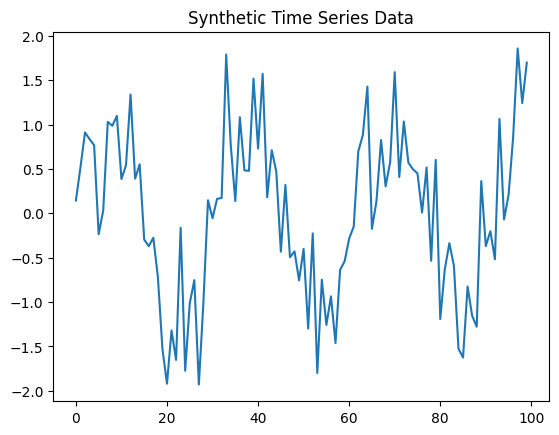

Epoch 0 loss: 1.4012227058410645
Epoch 10 loss: 1.3176900148391724
Epoch 20 loss: 1.497721552848816
Epoch 30 loss: 1.570195198059082
Epoch 40 loss: 1.5481326580047607
Epoch 50 loss: 1.5511677265167236
Epoch 60 loss: 1.534196138381958
Epoch 70 loss: 1.5101256370544434
Epoch 80 loss: 1.5746676921844482
Epoch 90 loss: 1.5255295038223267


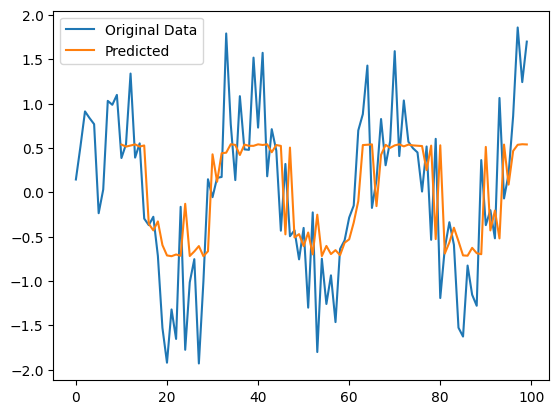

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic time series data
def generate_data():
    t = np.linspace(0, 20, 100)  # Create 100 points from 0 to 20
    y = np.sin(t) + np.random.normal(scale=0.5, size=t.shape)  # Sine wave with noise
    return y

data = generate_data()
plt.plot(data)
plt.title('Synthetic Time Series Data')
plt.show()

# Prepare the dataset
def create_inout_sequences(input_data, tw):  # tw -> time step window
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 10  # Number of time steps to look back
data = torch.FloatTensor(data).view(-1)
sequences = create_inout_sequences(data, seq_length)

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        rnn_out, hidden = self.rnn(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        return predictions[-1]

model = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for i in range(epochs):
    for seq, labels in sequences:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print(f'Epoch {i} loss: {single_loss.item()}')

with torch.no_grad():
    preds = []
    for seq, _ in sequences:
        preds.append(model(seq).item())
    plt.plot(data.numpy(), label='Original Data')
    plt.plot(np.arange(seq_length, seq_length + len(preds)), preds, label='Predicted')
    plt.legend()
    plt.show()
